In [1]:
%pip install caer kaggle tensorflow pillow scikit-image matplotlib pandas seaborn
%pip uninstall opencv-python --yes
%pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory '/home/studio-lab-user/.kaggle': File exists


In [3]:
%%writefile ~/.kaggle/kaggle.json

{"username":"<YOUR KAGGLE USERNAME>", "key":"<YOUR KAGGLE AUTH CODE>"}

Overwriting /home/studio-lab-user/.kaggle/kaggle.json


In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import gc
import shutil as sh

import caer 

In [1]:
!kaggle datasets download -d jasmcaus/massachusetts-roads-utoronto-trainvaltest-jpg
!unzip massachusetts-roads-utoronto-trainvaltest-jpg.zip

In [7]:
IMG_HEIGHT = IMG_WIDTH = 256
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

EPOCHS = 50
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

THRESH_VAL = 0.15

SEED = 56

# Defining Custom Loss functions and accuracy Metric.¶


In [8]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [9]:
train = caer.path.list_images("/home/studio-lab-user/sagemaker-studiolab-notebooks/AWS Disaster Response Hackathon 2021 (ML)/MassachusettsRoads/train/roads", recursive=True, use_fullpath=True)
val = caer.path.list_images("/home/studio-lab-user/sagemaker-studiolab-notebooks/AWS Disaster Response Hackathon 2021 (ML)/MassachusettsRoads/val/roads", recursive=True, use_fullpath=True)
test = caer.path.list_images("/home/studio-lab-user/sagemaker-studiolab-notebooks/AWS Disaster Response Hackathon 2021 (ML)/MassachusettsRoads/test/roads", recursive=True, use_fullpath=True)

# for i in val:
#     train.append(i)

# del val
# gc.collect()

print(len(train))
print(len(val))
print(len(test))

[INFO] 880 files found in 0.002897977828979492s
[INFO] 220 files found in 0.0011954307556152344s
[INFO] 71 files found in 0.0005404949188232422s
880
220
71


In [10]:
# Train
__train_roads = []
__train_masks = []
count = 0
for i in train:
    road_arr = caer.imread(i, target_size=IMG_SIZE)
    road = np.array(road_arr)
    arr = caer.imread(i.replace("/roads/", "/masks/"), target_size=IMG_SIZE)
    gray = caer.rgb2gray(arr)
    mask_arr = np.array(gray)
    mask = np.expand_dims(mask_arr, -1)
    
    __train_roads.append(road)
    __train_masks.append(mask)
    
    count += 1
    if count % 100 == 0:
        print(count)
    
    del arr
    del road_arr
    del mask_arr
    gc.collect()

train_roads = np.array(__train_roads)
train_masks = np.array(__train_masks)

del __train_roads
del __train_masks

print("TRAIN SET: ")
print(train_roads.shape)
print(train_masks.shape)

100
200
300
400
500
600
700
800
TRAIN SET: 
(880, 256, 256, 3)
(880, 256, 256, 1)


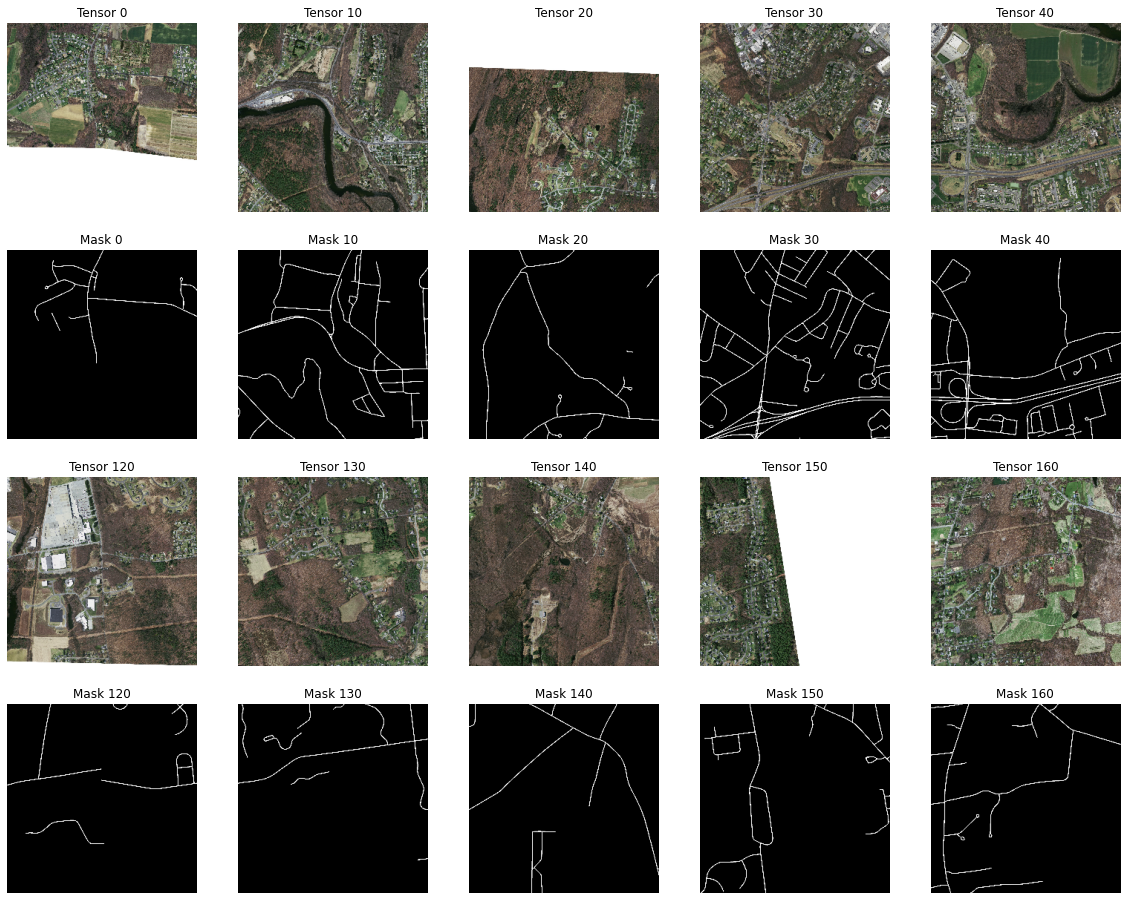

In [11]:
plt.figure(figsize=(20, 16))
x, y = 5, 2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(train_roads[pos])
        plt.title(f"Tensor {pos}")
        plt.axis('off')
        
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(train_masks[pos], cmap="gray")
        plt.title(f'Mask {pos}')
        plt.axis('off')
        
plt.show()

In [12]:
train_roads = train_roads.astype("float32")
train_masks = train_masks.astype("float32")

mean = np.mean(train_roads)
std = np.std(train_roads)

print(f"Mean = {mean}")
print(f"Std =   {std}")

train_roads -= mean
train_roads /= std
train_masks /= 255 # scale to [0, 1]

Mean = 105.30828857421875
Std =   72.63036346435547


In [13]:
# Test
__test_roads = []
__test_masks = []
count = 0
for i in test:
    road_arr = caer.imread(i, target_size=IMG_SIZE)
    road = np.array(road_arr)
    arr = caer.imread(i.replace("/roads/", "/masks/"), target_size=IMG_SIZE)
    gray = caer.rgb2gray(arr)
    mask_arr = np.array(gray)
    mask = np.expand_dims(mask_arr, -1)
    
    __test_roads.append(road)
    __test_masks.append(mask)
    
    count += 1
    if count % 100 == 0:
        print(count)
    
    del arr
    del road_arr
    del mask_arr
    gc.collect()

test_roads = np.array(__test_roads).astype("float32")
test_masks = np.array(__test_masks).astype("float32")

test_roads -= mean
test_masks /= std

del __test_roads
del __test_masks

print("TEST SET: ")
print(test_roads.shape)
print(test_masks.shape)

TEST SET: 
(71, 256, 256, 3)
(71, 256, 256, 1)


# Defining Our Model

In [14]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import *
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [15]:
def unet(input_size = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge6)
    conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)

    up7 = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge7)
    conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)

    up8 = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge8)
    conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)

    up9 = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge9)
    conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
    conv9 = Conv2D(2, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
    conv10 = Conv2D(1, 1, activation = "sigmoid")(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

In [16]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [18]:
model_path = "mass_roads_unet.h5"
checkpointer = ModelCheckpoint(
                    model_path,
                    monitor="val_loss",
                    mode="min",
                    save_best_only=True,
                    verbose=1
                )

# Early stopping prevents overfitting on training data
# Make sure the patience value for EarlyStopping > patience value for ReduceLROnPlateau, otherwise ReduceLROnPlateau will never be called.
earlystopper = EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=10,
                    verbose=1,
                    restore_best_weights=True
                )

lr_reducer = ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.1,
                    patience=4,
                    verbose=1,
                    epsilon=1e-4
                )

In [19]:
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
    optimizer=opt,
    loss=soft_dice_loss,
    metrics=[iou_coef, "accuracy"]
)

# model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = [iou_coef, 'accuracy'])

In [21]:
history = model.fit(
            train_roads,
            train_masks,
            validation_split=0.1,
            epochs=50,
            shuffle=True,
            batch_size = BATCH_SIZE,
            callbacks = [checkpointer, earlystopper, lr_reducer]
        )

### Uncomment only if using Data Augmentation
# history = model.fit_generator(
#                     train_generator,
#                     validation_data=val_generator,
#                     validation_steps=10,
#                     epochs=EPOCHS,
# #                     shuffle=True,
#                     steps_per_epoch=len(train_roads) // BATCH_SIZE,
#                     callbacks = [checkpointer, earlystopper, lr_reducer]
# )

2022-02-07 13:18:10.387999: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 622854144 exceeds 10% of free system memory.
2022-02-07 13:18:11.191214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 622854144 exceeds 10% of free system memory.


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.8745 - iou_coef: 0.0643 - accuracy: 0.6534
Epoch 00001: val_loss improved from inf to 0.89960, saving model to mass_roads_unet.h5
50/50 [==============================] - 59s 1s/step - loss: 0.8745 - iou_coef: 0.0643 - accuracy: 0.6534 - val_loss: 0.8996 - val_iou_coef: 0.0488 - val_accuracy: 0.8732 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.8053 - iou_coef: 0.0911 - accuracy: 0.8632
Epoch 00002: val_loss improved from 0.89960 to 0.86473, saving model to mass_roads_unet.h5
50/50 [==============================] - 49s 989ms/step - loss: 0.8053 - iou_coef: 0.0911 - accuracy: 0.8632 - val_loss: 0.8647 - val_iou_coef: 0.0664 - val_accuracy: 0.9239 - lr: 1.0000e-04
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.7718 - iou_coef: 0.1106 - accuracy: 0.8757
Epoch 00003: val_loss improved from 0.86473 to 0.85647, saving model to mass_roads_unet.h5
50/50 [======

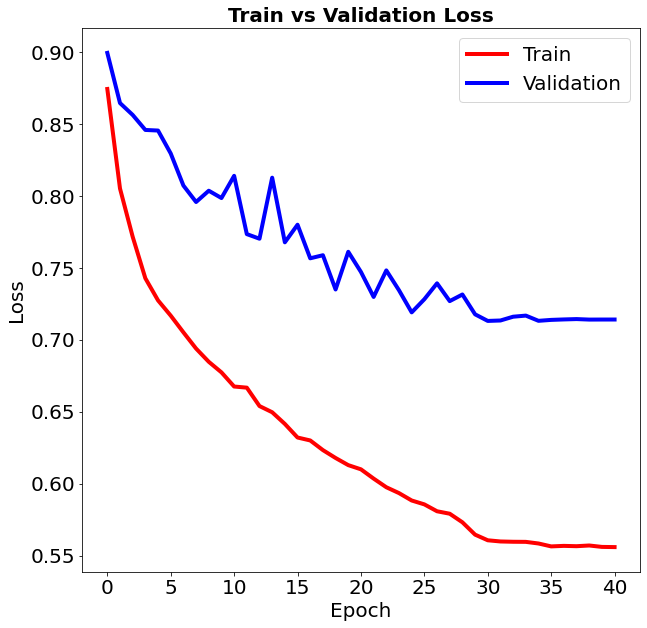

In [22]:
# Loss
plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"], linewidth=4, color="r")       
plt.plot(history.history["val_loss"], linewidth=4, color="b")
plt.title("Train vs Validation Loss", fontsize=20, fontweight="bold")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend(["Train", "Validation"], loc="upper right", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("loss.jpg")
plt.show()

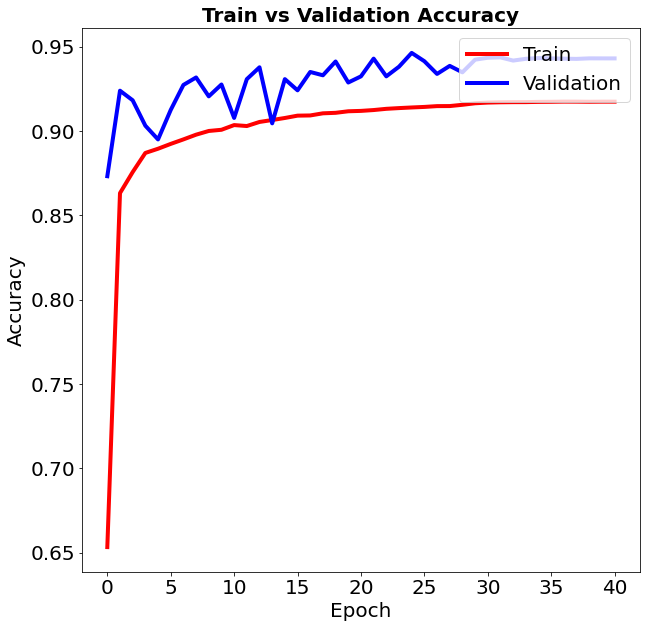

In [23]:
# Accuracy
plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], linewidth=4, color="r")       
plt.plot(history.history["val_accuracy"], linewidth=4, color="b")
plt.title("Train vs Validation Accuracy", fontsize=20, fontweight="bold")
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend(["Train", "Validation"], loc="upper right", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("accuracy.jpg")
plt.show()

In [24]:
from keras.models import model_from_json
from keras.models import load_model

# Serialize model to JSON
model_json = model.to_json()

with open("mass_roads_unet.json", "w") as json_file:
    json_file.write(model_json)

# Testing

In [25]:
model = load_model("./mass_roads_unet.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [26]:
model.evaluate(test_roads, test_masks)

3/3 [==============================] - 29s 3s/step - loss: 0.4470 - iou_coef: 0.3608 - accuracy: 0.8995


[0.44697844982147217, 0.3608182966709137, 0.8994520902633667]

In [27]:
predictions = model.predict(test_roads, verbose=1)
prediction_threshold = (predictions > THRESH_VAL).astype(np.uint8)

3/3 [==============================] - 1s 516ms/step


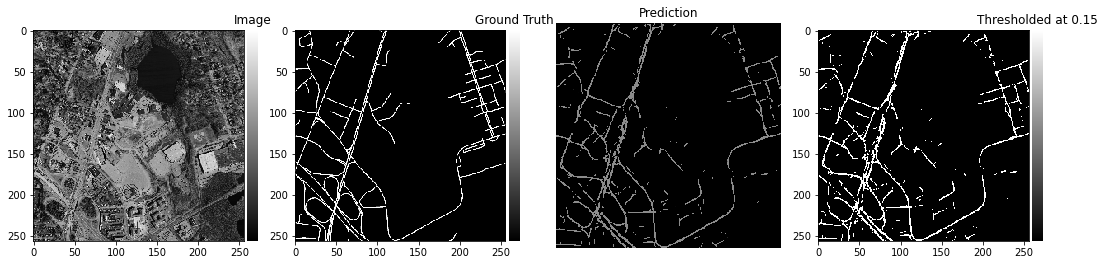

In [29]:
idx = random.randint(0, len(predictions))
num_samples = 1

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
    idx = random.randint(0, len(predictions))

    f.add_subplot(num_samples, 4, i)
    img = test_roads[idx][:,:,0]
    
    img += mean
    img *= std
    imshow(img, cmap="gray")

    plt.title("Image")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+1)
    imshow(np.squeeze(test_masks[idx][:,:,0]), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+2)
    imshow(np.squeeze(predictions[idx][:,:,0]))
    plt.title("Prediction")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+3)
    imshow(np.squeeze(prediction_threshold[idx][:,:,0]), cmap="gray")
    plt.title(f"Thresholded at {THRESH_VAL}")
    plt.axis('off')

plt.show()

In [ ]:
import pickle 
with open("history-dict.pickle", 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# (Optional) Upload model to an S3 Bucket

In [ ]:
# Please add code here to upload the `mass_roads_unet.h5` to an S3 bucket. We have removed the code so as not to publically display our AWS credentials. You may find this useful: https://awscli.amazonaws.com/v2/documentation/api/latest/reference/s3/cp.html